In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np
from skorch.callbacks import EpochScoring
from sklearn.preprocessing import StandardScaler
from skorch import NeuralNetRegressor
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.base import BaseEstimator, RegressorMixin


In [22]:
data = pd.read_csv("./train.csv")

spectrum = data.iloc[:, 6:]

#spectrum_filtered = pd.DataFrame(savgol_filter(spectrum, 7, 3, deriv = 2, axis = 0))
#spectrum_filtered_st = zscore(spectrum_filtered, axis = 1)

X = spectrum
y = data["PURITY"]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

standardizer = StandardScaler()
X_train_standardized = standardizer.fit_transform(X_train)
X_valid_standardized = standardizer.transform(X_valid)

# Convert to tensors
X_train_tensor = torch.tensor(X_train_standardized, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)
X_valid_tensor = torch.tensor(X_valid_standardized, dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid.values, dtype=torch.float32).reshape(-1, 1)

In [48]:

# Définir le modèle de réseau de neurones simple
class SimpleNN(nn.Module):
    def __init__(self, input_size, fc1_out_features=50, fc2_out_features=1):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, fc1_out_features)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(fc1_out_features, fc2_out_features)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Définir la classe NeuralNetRegressor
class NeuralNetRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, input_size, eta=0.001, max_epochs=100, fc1_out_features=50, fc2_out_features=1, batch=10):
        self.input_size = input_size
        self.eta = eta
        self.max_epochs = max_epochs
        self.fc1_out_features = fc1_out_features
        self.fc2_out_features = fc2_out_features
        self.batch = batch
        self.model = SimpleNN(input_size, fc1_out_features, fc2_out_features)
        self.criterion = nn.MSELoss()
    
    def fit(self, X, y):
        optimizer = optim.Adam(self.model.parameters(), lr=self.eta)
        X_tensor = torch.tensor(X, dtype=torch.float32)
        y_tensor = torch.tensor(y, dtype=torch.float32)
        for epoch in range(self.max_epochs):
            self.model.train()
            optimizer.zero_grad()
            outputs = self.model(X_tensor)
            loss = self.criterion(outputs, y_tensor)
            loss.backward()
            optimizer.step()
        return self
    
    def predict(self, X):
        self.model.eval()
        X_tensor = torch.tensor(X, dtype=torch.float32)
        with torch.no_grad():
            outputs = self.model(X_tensor)
        return outputs.numpy()
    
    def parameters(self):
        return self.model.parameters()

# Initialiser le modèle
input_size = X_train_tensor.shape[1]
net = NeuralNetRegressor(input_size=input_size)

# Définir les paramètres pour GridSearch
params = {
    'eta': [0.001, 0.005, 0.01],
    'max_epochs': [20, 25],
    'fc1_out_features': np.arange(100, 150, 25),
    'fc2_out_features': np.arange(64, 130, 32),
    'batch': [45, 50, 55]
}

# Initialiser GridSearchCV
grid_search = GridSearchCV(net, params, refit=True, cv=5, scoring='neg_mean_squared_error', verbose=0)

# Entraîner le modèle avec GridSearch
grid_result = grid_search.fit(X_train_tensor, y_train_tensor)
nouveau_model = grid_result.best_estimator_

print("Best MSE: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
criterion = nn.MSELoss()
batch_size = grid_result.best_params_["batch"]
batches_per_epoch = len(X_train_tensor) // batch_size

# Entraîner le modèle avec la descente de gradient
def gradient_descent(model, criterion, X_train_tensor, y_train_tensor, eta=0.01, n_epochs=100, batch_size=10):
    optimizer = optim.Adam(model.parameters(), lr=eta)
    learning_curve = []
    steps = []
    batches_per_epoch = len(X_train_tensor) // batch_size
    
    for epoch in range(n_epochs):
        for i in range(batches_per_epoch):
            start = i * batch_size
            end = start + batch_size
            Xbatch = X_train_tensor[start:end]
            ybatch = y_train_tensor[start:end]

            # Forward pass
            y_pred = model(Xbatch)
            loss = criterion(y_pred, ybatch)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            learning_curve.append(loss.item())
            steps.append(epoch * batches_per_epoch + i + 1)
        
            # Vérifiez les pertes pendant l'entraînement
            if torch.isnan(loss).any().item():
                print(f"NaN loss detected at epoch {epoch}, batch {i}")
    
    return model, learning_curve, steps

# Entraîner le modèle avec la descente de gradient
model, learning_curve, steps = gradient_descent(nouveau_model.model, criterion, X_train_tensor, y_train_tensor, eta=grid_result.best_params_["eta"], n_epochs=grid_result.best_params_["max_epochs"], batch_size=batch_size)

/var/folders/93/xgf_b79s5sd1vjn_794f14ym0000gn/T/ipykernel_6083/2759479965.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X, dtype=torch.float32)
/var/folders/93/xgf_b79s5sd1vjn_794f14ym0000gn/T/ipykernel_6083/2759479965.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y, dtype=torch.float32)
/var/folders/93/xgf_b79s5sd1vjn_794f14ym0000gn/T/ipykernel_6083/2759479965.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X, dtype=torch.float32)
/var/folders/93/

Best MSE: -355.349091 using {'batch': 50, 'eta': 0.01, 'fc1_out_features': 125, 'fc2_out_features': 64, 'max_epochs': 25}


X_valid_tensor contains NaN: False
y_valid_tensor contains NaN: False
y_pred contains NaN: False
MSE : 39.43144
t_score : 0.6269230842590332


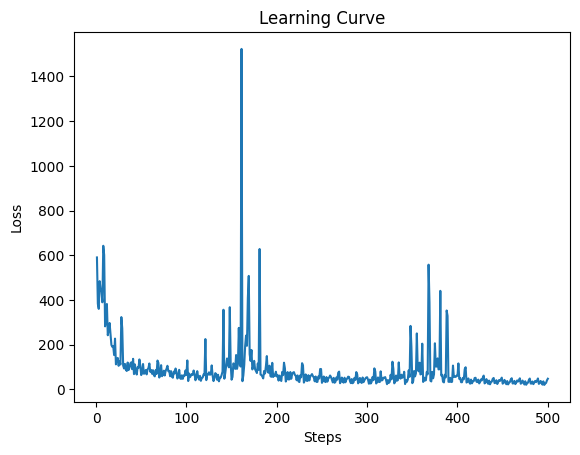

In [49]:
# Vérifiez les données d'entrée
print("X_valid_tensor contains NaN:", torch.isnan(X_valid_tensor).any().item())
print("y_valid_tensor contains NaN:", torch.isnan(y_valid_tensor).any().item())

# Générer les prédictions sur les données de validation
model.eval()
with torch.no_grad():
    y_pred = model(X_valid_tensor).detach().numpy()

# Vérifiez les sorties du modèle
print("y_pred contains NaN:", np.isnan(y_pred).any())

# Calculer la MSE
mse = np.mean((y_pred - y_valid_tensor.numpy())**2)
print("MSE :", mse)

# Calculer le t_score
predictions_tensor = torch.tensor(y_pred, dtype=torch.float32)
t_score = torch.mean((torch.abs(predictions_tensor - y_valid_tensor) <= 5).float())
print("t_score :", t_score.item())

# Afficher la courbe d'apprentissage
import matplotlib.pyplot as plt
plt.plot(steps, learning_curve)
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.show()

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, RegressorMixin
import numpy as np

# Charger les données
data = pd.read_csv("./train.csv")
spectrum = data.iloc[:, 6:]
X = spectrum
y = data["PURITY"]

# Diviser les données en jeu d'entraînement et de validation
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardiser les données
standardizer = StandardScaler()
X_train_standardized = standardizer.fit_transform(X_train)
X_valid_standardized = standardizer.transform(X_valid)

# Convertir les données en tenseurs PyTorch
X_train_tensor = torch.tensor(X_train_standardized, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)
X_valid_tensor = torch.tensor(X_valid_standardized, dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid.values, dtype=torch.float32).reshape(-1, 1)

# Définir le modèle de réseau de neurones simple
class SimpleNN(nn.Module):
    def __init__(self, input_size, fc1_out_features=50, fc2_out_features=1):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, fc1_out_features)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(fc1_out_features, fc2_out_features)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Définir la classe NeuralNetRegressor
class NeuralNetRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, input_size, eta=0.001, max_epochs=100, fc1_out_features=50, fc2_out_features=1, batch_size=10):
        self.input_size = input_size
        self.eta = eta
        self.max_epochs = max_epochs
        self.fc1_out_features = fc1_out_features
        self.fc2_out_features = fc2_out_features
        self.batch_size = batch_size
        self.model = SimpleNN(input_size, fc1_out_features, fc2_out_features)
        self.criterion = nn.MSELoss()
    
    def fit(self, X, y):
        # Convertir les données en tenseurs
        X_tensor = torch.tensor(X, dtype=torch.float32)
        y_tensor = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)
        
        # Créer un DataLoader pour gérer les batchs
        dataset = torch.utils.data.TensorDataset(X_tensor, y_tensor)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
        
        # Optimiseur
        optimizer = optim.SGD(self.model.parameters(), lr=self.eta)
        
        # Entraînement
        for epoch in range(self.max_epochs):
            self.model.train()
            for X_batch, y_batch in dataloader:
                optimizer.zero_grad()
                outputs = self.model(X_batch)
                loss = self.criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()
        return self
    
    def predict(self, X):
        self.model.eval()
        X_tensor = torch.tensor(X, dtype=torch.float32)
        with torch.no_grad():
            outputs = self.model(X_tensor)
        return outputs.numpy()
    
    def parameters(self):
        return self.model.parameters()

# Initialiser le modèle
input_size = X_train_tensor.shape[1]
net = NeuralNetRegressor(input_size=input_size)

# Définir les paramètres pour GridSearch
params = {
    'eta': [0.001, 0.005, 0.01],
    'max_epochs': [20, 50],
    'fc1_out_features': [50, 128],
    'fc2_out_features': [64, 128],
    'batch_size': [10, 20]  # Taille des batchs
}

# Initialiser GridSearchCV
grid_search = GridSearchCV(net, params, refit=True, cv=3, scoring='neg_mean_squared_error', verbose=1)

# Entraîner le modèle avec GridSearch
grid_result = grid_search.fit(X_train_standardized, y_train)
nouveau_model = grid_result.best_estimator_

print("Best MSE: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# Descente de gradient avec arrêt précoce
def gradient_descent(model, criterion, X_train_tensor, y_train_tensor, eta=0.01, n_epochs=100, batch_size=10, patience=5):
    optimizer = optim.SGD(model.parameters(), lr=eta)
    learning_curve = []
    batches_per_epoch = len(X_train_tensor) // batch_size
    best_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(n_epochs):
        epoch_loss = 0
        for i in range(batches_per_epoch):
            start = i * batch_size
            end = start + batch_size
            Xbatch = X_train_tensor[start:end]
            ybatch = y_train_tensor[start:end]

            # Forward pass
            y_pred = model(Xbatch)
            loss = criterion(y_pred, ybatch)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
        
        epoch_loss /= batches_per_epoch
        learning_curve.append(epoch_loss)
        """
        # Early stopping
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch}")
                break
        """
    
    return model, learning_curve

# Entraîner le modèle avec les meilleurs paramètres
final_model, learning_curve = gradient_descent(
    nouveau_model.model, 
    nn.MSELoss(), 
    X_train_tensor, 
    y_train_tensor, 
    eta=grid_result.best_params_["eta"], 
    n_epochs=grid_result.best_params_["max_epochs"], 
    batch_size=grid_result.best_params_["batch_size"]
)

print("Final training complete.")


Fitting 3 folds for each of 48 candidates, totalling 144 fits


/Users/amelielheritier/anaconda3/envs/MLCourse/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/amelielheritier/anaconda3/envs/MLCourse/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/amelielheritier/anaconda3/envs/MLCourse/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/amelielheritier/anaconda3/envs/MLCourse/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/Users/amelielheritier/anaconda3/envs/MLCourse/lib/python3.10/site-packages/sklear

KeyboardInterrupt: 